<a href="https://colab.research.google.com/github/ishakaran808/Time-series-analysis/blob/main/Electricity_Consumption_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torch torchvision torchaudio

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [2]:
# Load dataset
df = pd.read_csv('Electric_Production.csv')  # Replace with your dataset path
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)

# Display the first few rows of the dataset
print(df.head())


              Value
DATE               
1985-01-01  72.5052
1985-02-01  70.6720
1985-03-01  62.4502
1985-04-01  57.4714
1985-05-01  55.3151


In [3]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_values = scaler.fit_transform(df[['Value']])

# Convert data to PyTorch tensors
scaled_values = torch.FloatTensor(scaled_values).view(-1)

# Define a function to create sequences
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length:i+seq_length+1]
        sequences.append((seq, label))
    return sequences

seq_length = 30  # Number of time steps
sequences = create_sequences(scaled_values, seq_length)

# Split into train and test datasets
train_size = int(len(sequences) * 0.8)
train_sequences = sequences[:train_size]
test_sequences = sequences[train_size:]

# Create DataLoader
def create_dataloader(sequences, batch_size):
    X, y = zip(*sequences)
    X = torch.stack(X)
    y = torch.stack(y)
    dataset = TensorDataset(X, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

batch_size = 64
train_loader = create_dataloader(train_sequences, batch_size)
test_loader = create_dataloader(test_sequences, batch_size)

In [4]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = 1
hidden_size = 64
num_layers = 2
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)

In [5]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 50

for epoch in range(num_epochs):
    for i, (sequences, labels) in enumerate(train_loader):
        sequences = sequences.unsqueeze(-1).to(torch.float32)
        labels = labels.to(torch.float32)

        outputs = model(sequences)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluating the model
model.eval()
with torch.no_grad():
    y_pred = []
    y_true = []
    for sequences, labels in test_loader:
        sequences = sequences.unsqueeze(-1).to(torch.float32)
        outputs = model(sequences)
        y_pred.extend(outputs.numpy())
        y_true.extend(labels.numpy())

    y_pred = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))
    y_true = scaler.inverse_transform(np.array(y_true).reshape(-1, 1))
    mse = mean_squared_error(y_true, y_pred)
    print(f'Mean Squared Error: {mse:.4f}')

Epoch [10/50], Loss: 0.0511
Epoch [20/50], Loss: 0.0356
Epoch [30/50], Loss: 0.0483
Epoch [40/50], Loss: 0.0555
Epoch [50/50], Loss: 0.0408
Mean Squared Error: 94.9853


torch.Size([1, 30, 1])
tensor([[0.2203]])
torch.Size([1, 30, 1])
tensor([[0.2157]])
torch.Size([1, 30, 1])
tensor([[0.2184]])
torch.Size([1, 30, 1])
tensor([[0.2247]])
torch.Size([1, 30, 1])
tensor([[0.2307]])
torch.Size([1, 30, 1])
tensor([[0.2343]])
torch.Size([1, 30, 1])
tensor([[0.2349]])
torch.Size([1, 30, 1])
tensor([[0.2358]])
torch.Size([1, 30, 1])
tensor([[0.2373]])
torch.Size([1, 30, 1])
tensor([[0.2387]])
torch.Size([1, 30, 1])
tensor([[0.2392]])
torch.Size([1, 30, 1])
tensor([[0.2378]])
torch.Size([1, 30, 1])
tensor([[0.2350]])
torch.Size([1, 30, 1])
tensor([[0.2322]])
torch.Size([1, 30, 1])
tensor([[0.2310]])
torch.Size([1, 30, 1])
tensor([[0.2313]])
torch.Size([1, 30, 1])
tensor([[0.2311]])
torch.Size([1, 30, 1])
tensor([[0.2285]])
torch.Size([1, 30, 1])
tensor([[0.2257]])
torch.Size([1, 30, 1])
tensor([[0.2251]])
torch.Size([1, 30, 1])
tensor([[0.2244]])
torch.Size([1, 30, 1])
tensor([[0.2251]])
torch.Size([1, 30, 1])
tensor([[0.2252]])
torch.Size([1, 30, 1])
tensor([[0.

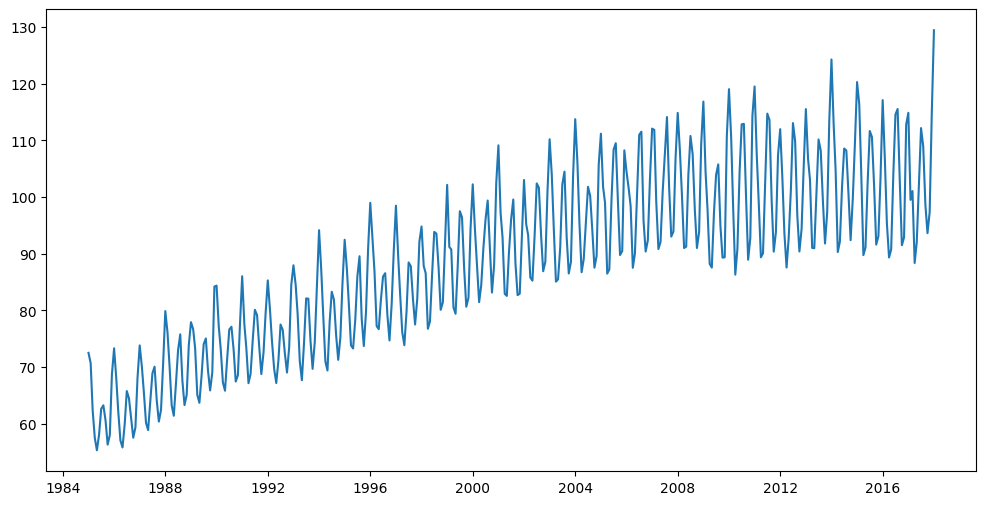

In [6]:
# Forecasting
model.eval()
with torch.no_grad():
    # Initialize the last sequence with the most recent data
    last_sequence = scaled_values[-seq_length:].unsqueeze(0).unsqueeze(-1)  # Shape: [1, seq_length, 1]

    forecast = []
    for _ in range(30):  # Forecasting next 30 time steps
        # Get the model's prediction for the next time step
        output = model(last_sequence)
        print(last_sequence.shape)
        print(output)
        # Store the predicted value
        forecast.append(output.item())

        # Prepare the new sequence for the next iteration
        # Output needs to be reshaped to match the dimensions of the sequence
        new_sequence = torch.cat((last_sequence[:, 1:, :], output.unsqueeze(0)), dim=1)
        last_sequence = new_sequence

# Convert the forecast to the original scale
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Value'], label='Actual Data')

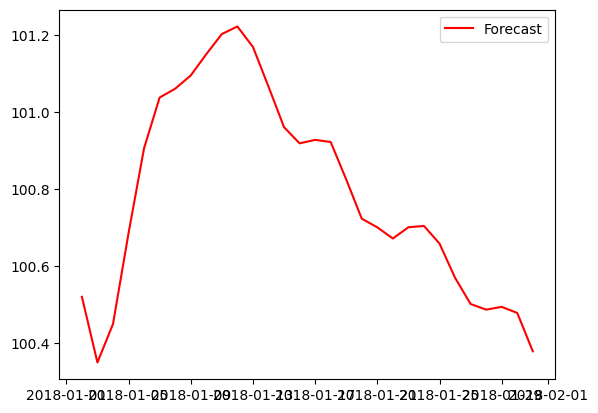

In [7]:
# Create forecast dates
forecast_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30)
plt.plot(forecast_dates, forecast, label='Forecast', color='red')
plt.legend()
plt.show()